In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error

In [2]:
train_path = os.path.join('..','data','new_train.csv')
test_path = os.path.join('..','data','new_test.csv')
# monthly_card_path = os.path.join('..','data','monthly_card_features.csv')

In [3]:
train_df = pd.read_csv(train_path, index_col=0)
test_df = pd.read_csv(test_path,index_col=0)
# monthly_card_df = pd.read_csv(monthly_card_path)

In [4]:
test_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,tof,recency,frequency,log_freq,amt,...,max_amt,n_declines,log_n_declines,prop_new,merch_cat_1_Y,merch_cat_2_1,merch_cat_2_2,merch_cat_2_3,merch_cat_2_4,merch_cat_2_5
0,2017-04,C_ID_0ab67a22ab,3,3,1,391,61,71,4.262680,-42.510888,...,0.235676,24.0,3.178054,0.042254,23,48,0,0,0,0
1,2017-01,C_ID_130fd0cbdd,2,3,0,472,10,87,4.465908,-55.081212,...,0.318818,1.0,0.000000,0.103448,4,0,0,1,82,0
2,2017-08,C_ID_b709037bc5,5,1,1,248,48,15,2.708050,4.708978,...,2.525866,4.0,1.386294,0.133333,2,1,0,0,0,12
3,2017-12,C_ID_d27d835a9f,2,1,0,147,13,36,3.583519,-19.434389,...,0.087965,0.0,0.000000,0.277778,1,34,0,0,0,1
4,2015-12,C_ID_2b5e3df5c2,5,1,1,482,18,116,4.753590,37.204381,...,15.782255,23.0,3.135494,0.051724,0,4,0,6,106,0


In [5]:
list(train_df)

['first_active_month',
 'card_id',
 'feature_1',
 'feature_2',
 'feature_3',
 'target',
 'tof',
 'recency',
 'frequency',
 'log_freq',
 'amt',
 'avg_amt',
 'charge_per_day',
 'log_charge_per_day',
 'max_amt',
 'n_declines',
 'log_n_declines',
 'prop_new',
 'merch_cat_1_Y',
 'merch_cat_2_1',
 'merch_cat_2_2',
 'merch_cat_2_3',
 'merch_cat_2_4',
 'merch_cat_2_5']

In [6]:
model_cols = ['feature_1',
 'feature_2',
 'feature_3',
 'tof',
 'recency',
 'log_freq',
 'amt',
 'avg_amt',
 'charge_per_day',
 'log_charge_per_day',
 'max_amt',
 'n_declines',
 'log_n_declines',
 'prop_new',
 'merch_cat_1_Y',
 'merch_cat_2_1',
 'merch_cat_2_2',
 'merch_cat_2_3',
 'merch_cat_2_4',
 'merch_cat_2_5']

In [7]:
numeric_cols = ['feature_1',
 'feature_2',
 'tof',
 'recency',
 'log_freq',
 'amt',
 'avg_amt',
 'charge_per_day',
 'log_charge_per_day',
 'max_amt',
 'n_declines',
 'log_n_declines',
 'prop_new']

cat_cols = ['feature_3',
'merch_cat_1_Y',
 'merch_cat_2_1',
 'merch_cat_2_2',
 'merch_cat_2_3',
 'merch_cat_2_4',
 'merch_cat_2_5']

## Oversampling


In [8]:
train_df_out = train_df[(train_df['target'] > 4)]
train_df_out = pd.concat([train_df_out, train_df_out, train_df_out])
train_df_out = pd.concat([train_df_out,train_df_out])

In [9]:
train_df.shape

(201917, 24)

In [10]:
# X_train, X_test, y_train, y_test = train_test_split(train_df[model_cols],train_df['target'],test_size=0.2)

X_train = train_df[model_cols]
y_train = train_df['target']
x_test = test_df[model_cols]

## Scaling

subract by min and divide by max

In [11]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train),columns = X_train.columns,index=X_train.index)

/Users/henrypark/anaconda/envs/tfdeeplearning/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [12]:
scaler = MinMaxScaler()
scaler.fit(x_test)
x_test = pd.DataFrame(data=scaler.transform(x_test),columns = x_test.columns,index=x_test.index)

/Users/henrypark/anaconda/envs/tfdeeplearning/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Boosted Tree Regressor Using Tensorflow

In [879]:
tf_columns = []
for col in model_cols:
    #tf_columns.append(tf.feature_column.numeric_column(col))
    temp = tf.feature_column.numeric_column(col)
    quart = sorted(list(set(X_train[col].quantile([0.15,0.5,0.85]))))
    tf_columns.append(tf.feature_column.bucketized_column(source_column=temp, boundaries=quart))

# tf_columns = []
# for col in numeric_cols:
#     tf_columns.append(tf.feature_column.numeric_column(col))
# for col in cat_cols:
#     tf_columns.append(tf.feature_column.indicator_column(col))

In [880]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=10,num_epochs=1000,
                                            shuffle=True)

In [881]:
n_batches_per_layer = 0.5 * X_train.shape[0] // 100
n_batches_per_layer

1009.0

In [882]:
# model = tf.estimator.DNNClassifier(hidden_units=[10,10,10],feature_columns=tf_columns)
model = tf.estimator.BoostedTreesRegressor(
    feature_columns=tf_columns,
    n_batches_per_layer=100,
    n_trees=100,
    l1_regularization=0.01,
    max_depth=5)

# model = estimator = tf.estimator.DNNRegressor(hidden_units=[1024, 512, 256],
#                                               feature_columns=tf_columns,
#                                              optimizer = tf.train.ProximalAdagradOptimizer(
#       learning_rate=0.1,
#       l1_regularization_strength=0.001
#     ))


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a313a90f0>, '_keep_checkpoint_max': 5, '_num_worker_replicas': 1, '_train_distribute': None, '_task_type': 'worker', '_eval_distribute': None, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_is_chief': True, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_num_ps_replicas': 0, '_protocol': None, '_experimental_distribute': None, '_device_fn': None, '_task_id': 0, '_tf_random_seed': None, '_model_dir': '/var/folders/_y/f4nlgpcs6x79pmncgymhg4hh0000gn/T/tmpnjimulla', '_service': None, '_global_id_in_cluster': 0, '_evaluation_master': '', '_master': '', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
}


In [883]:
model.train(input_fn=input_func,steps=15000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/_y/f4nlgpcs6x79pmncgymhg4hh0000gn/T/tmpnjimulla/model.ckpt.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:loss = 1.4292439, step = 1
INFO:tensorflow:global_step/sec: 204.057
INFO:tensor

INFO:tensorflow:global_step/sec: 276.692
INFO:tensorflow:loss = 7.786319, step = 7301 (0.359 sec)
INFO:tensorflow:global_step/sec: 273.166
INFO:tensorflow:loss = 4.220661, step = 7401 (0.368 sec)
INFO:tensorflow:global_step/sec: 283.686
INFO:tensorflow:loss = 4.6054626, step = 7501 (0.350 sec)
INFO:tensorflow:global_step/sec: 265.111
INFO:tensorflow:loss = 1.6732649, step = 7601 (0.380 sec)
INFO:tensorflow:global_step/sec: 281.257
INFO:tensorflow:loss = 2.590366, step = 7701 (0.353 sec)
INFO:tensorflow:global_step/sec: 285.56
INFO:tensorflow:loss = 1.1324402, step = 7801 (0.351 sec)
INFO:tensorflow:global_step/sec: 288.567
INFO:tensorflow:loss = 9.568944, step = 7901 (0.346 sec)
INFO:tensorflow:global_step/sec: 280.783
INFO:tensorflow:loss = 0.7030982, step = 8001 (0.357 sec)
INFO:tensorflow:global_step/sec: 281.488
INFO:tensorflow:loss = 1.671632, step = 8101 (0.357 sec)
INFO:tensorflow:global_step/sec: 266.77
INFO:tensorflow:loss = 1.2514412, step = 8201 (0.373 sec)
INFO:tensorflow:g

## Neural Network Using Tensorflow

In [ ]:
tf_columns = []
for col in model_cols:
    tf_columns.append(tf.feature_column.numeric_column(col))

In [ ]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train ,batch_size=10,num_epochs=1000,
                                            shuffle=True)

In [ ]:
model = tf.estimator.DNNRegressor(hidden_units=[64,32,16],feature_columns=tf_columns)

In [ ]:
model.train(input_fn=input_func,steps=10000)

## Predictions with Tensorflow Models

In [884]:
predict_input_func = tf.estimator.inputs.pandas_input_fn(
      x=x_test,
      batch_size=10,
      num_epochs=1,
      shuffle=False)

In [885]:
pred_gen = model.predict(predict_input_func)

In [886]:
predictions = list(pred_gen)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/_y/f4nlgpcs6x79pmncgymhg4hh0000gn/T/tmpnjimulla/model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [887]:
final_preds = []
for pred in predictions:
    final_preds.append(pred['predictions'][0])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a25ec4e48>]],
      dtype=object)

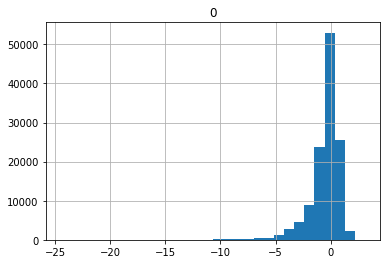

In [891]:
pd.DataFrame(final_preds).hist(bins=30)

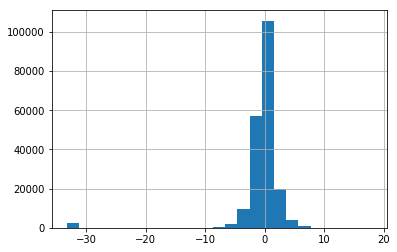

In [839]:
y_train.hist(bins=25)

In [889]:
min(final_preds)

-24.51375

In [890]:
max(final_preds)

3.147375

In [362]:
sum([i < -7 for i in final_preds])

0

In [325]:
sum(y_train > 5)

1742

In [892]:
submission = pd.DataFrame(final_preds)
submission.columns=['target']
submission = pd.concat([test_df['card_id'], submission], axis=1)
submission.to_csv('submission.csv', index=False)

## Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

In [25]:
train_df['target_bin'] = train_df['target'] < -7

##### Oversampling

In [26]:
train_df_out = train_df[(train_df['target'] < -7)]
train_df_out = pd.concat([train_df_out, train_df_out, train_df_out, train_df_out, train_df_out])
train_df_out = pd.concat([train_df_out,train_df_out])
train_df_out = pd.concat([train_df_out,train_df_out])
train_df_out = pd.concat([train_df_out,train_df_out])

In [27]:
train_df_out = pd.concat([train_df_out, train_df])

In [28]:
X_train_1 = train_df_out[model_cols]

##### Scaling for convergence

In [29]:
scaler = MinMaxScaler()
scaler.fit(X_train_1)
X_train_1 = pd.DataFrame(data=scaler.transform(X_train_1),columns = X_train_1.columns,index=X_train_1.index)

/Users/henrypark/anaconda/envs/tfdeeplearning/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [43]:
X_train_orig = pd.DataFrame(data=scaler.transform(train_df[model_cols]),columns = train_df[model_cols].columns,index=train_df[model_cols].index)

In [31]:
Os = sum(train_df_out['target_bin'])/train_df_out['target_bin'].shape[0]
O = sum(train_df['target_bin'])/train_df['target_bin'].shape[0]

In [32]:
clf = LogisticRegression(random_state=0, solver='liblinear',multi_class='ovr').fit(X_train_1, train_df_out['target_bin'])

In [44]:
prob_s = clf.predict_proba(X_train_orig)
prob_s = prob_s[:,0]

In [45]:
new_prob = prob_s * O/(Os - prob_s*(Os-O))

In [73]:
prediction_log = new_prob > 0.8

In [74]:
prediction_log[0:5]

array([False, False, False, False, False])

In [75]:
train_df['target_bin'].as_matrix()[0:5]

/Users/henrypark/anaconda/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([False, False, False, False, False])

In [76]:
train_df['target_bin'].as_matrix()[0:5] == prediction_log[0:5]

/Users/henrypark/anaconda/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([ True,  True,  True,  True,  True])

In [77]:
sum(prediction_log == train_df['target_bin'].as_matrix())/train_df['target_bin'].shape[0]

/Users/henrypark/anaconda/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


0.9869847511601302

In [78]:
1-sum(train_df['target_bin'])/train_df['target_bin'].shape[0]

0.9871828523601281